In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_json('/kaggle/input/wildfiredata/wildfire_collection_feature_engineering_final.json')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659376 entries, 0 to 659375
Data columns (total 32 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _id       659376 non-null  object 
 1   cfb       659376 non-null  int64  
 2   locality  659376 non-null  object 
 3   rep_date  659376 non-null  object 
 4   lat       659376 non-null  float64
 5   lon       659376 non-null  float64
 6   temp      659376 non-null  float64
 7   wd        659376 non-null  int64  
 8   elev      659376 non-null  int64  
 9   rh        659376 non-null  int64  
 10  pcuring   659376 non-null  int64  
 11  day       659376 non-null  int64  
 12  ros       659376 non-null  float64
 13  year      659376 non-null  int64  
 14  month     659376 non-null  int64  
 15  hfi       659376 non-null  int64  
 16  tfc0      659376 non-null  float64
 17  sfl       659376 non-null  float64
 18  bui_lag2  659376 non-null  float64
 19  bui       659376 non-null  float64
 20  cfl 

In [4]:
df.drop(columns='_id', inplace=True)

In [5]:
from datetime import datetime

def return_date(date_string):
    #date_dict = eval(date_string)  # Convert the string to a dictionary
    date_value = date_string['$date']  # Get the value of the '$date' key
    return datetime.strptime(date_value, "%Y-%m-%dT%H:%M:%S.%fZ").date()  # Convert the string to a date object

df['rep_date'] = df['rep_date'].apply(return_date)
df.head()

,cfb,locality,rep_date,lat,lon,temp,wd,elev,rh,pcuring,...,dmc_lag5,dmc,sfc,dmc_lag7,bui_lag4,bfc,tfc,isi,bui_lag5,fwi_lag7
0,0,100 Mile House,2021-01-09,51.627403,-121.285294,-0.926,328,917,78,94,...,1.331,1.331,0.07,1.331,2.53,2.180375,0.07,0.046,2.53,0.015
1,0,100 Mile House,2021-01-10,51.547768,-121.402448,-0.926,328,917,78,94,...,1.331,1.331,0.07,1.331,2.53,2.180375,0.07,0.046,2.53,0.015
2,0,100 Mile House,2021-01-11,51.547768,-121.402448,-0.926,328,917,78,94,...,1.331,1.331,0.07,1.331,2.53,2.180375,0.07,0.046,2.53,0.015
3,0,100 Mile House,2021-01-12,51.547768,-121.402448,-0.926,328,917,78,94,...,1.331,1.331,0.07,1.331,2.53,2.180375,0.07,0.046,2.53,0.015
4,0,100 Mile House,2021-01-13,51.547768,-121.402448,-0.926,328,917,78,94,...,1.331,1.331,0.07,1.331,2.53,2.180375,0.07,0.046,2.53,0.015


In [6]:
df['cfb'] = df['cfb'].astype(float)

In [7]:
def create_lagged_features(df, features, lags):
    for feature in features:
        for lag in lags:
            df[f'{feature}_lag{lag}'] = df[feature].shift(lag)
    return df

# Define lag features
features_to_lag = ['cfb', 'dmc', 'temp', 'tfc', 'ros', 'pcuring', 'bfc', 'hfi']
lags = [1, 2, 3, 5, 6, 7]

# Create lagged features
df = create_lagged_features(df, features_to_lag, lags)

# Drop rows with NaN values created by lagging
df.dropna(inplace=True)

Split train and test data

In [8]:
import datetime

split_date = datetime.date(2023, 7, 1)
train_data = df[df['rep_date'] < split_date]
test_data = df[df['rep_date'] >= split_date]

In [9]:
train = train_data.reset_index()
train = (train.merge((train[['rep_date']].drop_duplicates(ignore_index=True).rename_axis('time_idx'))\
                     .reset_index(), on = ['rep_date'])).drop("rep_date", axis=1)

In [10]:
# Check for duplicates
duplicates = train[train.duplicated(['locality', 'time_idx'], keep=False)]
print("Duplicate rows:")
print(duplicates)

Duplicate rows:
         index   cfb        locality        lat         lon       temp   wd  \
193        200  63.0  100 Mile House  51.542999 -121.434998  26.851000  177   
194        201   0.0  100 Mile House  51.526001 -121.428001  26.940001  177   
195        202   0.0  100 Mile House  51.530998 -121.410004  26.900000  177   
196        203   0.0  100 Mile House  51.530998 -121.411003  25.910000  353   
197        204  35.0  100 Mile House  51.528999 -121.422997  25.934000  353   
...        ...   ...             ...        ...         ...        ...  ...   
658166  659367   0.0           Zhoda  49.299700  -96.576300  24.204000  152   
658167  659368   0.0           Zhoda  49.298000  -96.568900  24.204000  152   
658172  659373   0.0           Zhoda  49.282500  -96.587500  28.539000  103   
658173  659374   0.0           Zhoda  49.291300  -96.580100  28.561000  103   
658174  659375   0.0           Zhoda  49.279000  -96.578000  28.538000  103   

        elev  rh  pcuring  ...  bfc

In [11]:
# Aggregate duplicate rows (using mean as an example)
train_unique = train.groupby(['locality', 'time_idx']).mean().reset_index()

# Verify that we now have unique combinations
assert train_unique.duplicated(['locality', 'time_idx']).sum() == 0, "Still have duplicates after aggregation"

In [12]:
# Create a complete time series for each locality
full_index = pd.MultiIndex.from_product(
    [train_unique['locality'].unique(), 
     range(train_unique['time_idx'].min(), train_unique['time_idx'].max() + 1)],
    names=['locality', 'time_idx']
)

# Reindex the dataframe and reset index to reintroduce locality and time_idx as columns
train_filled = train_unique.set_index(['locality', 'time_idx']).reindex(full_index).reset_index()

# Check the presence of 'locality' column
print(train_filled.columns)

# Forward fill the missing values within each group, but keep locality and time_idx intact
train_filled.update(train_filled.groupby('locality').ffill())

# If needed, backward fill remaining NaN values after forward fill
train_filled.update(train_filled.groupby('locality').bfill())

# Resulting DataFrame
print(train_filled)

Index(['locality', 'time_idx', 'index', 'cfb', 'lat', 'lon', 'temp', 'wd',
       'elev', 'rh', 'pcuring', 'day', 'ros', 'year', 'month', 'hfi', 'tfc0',
       'sfl', 'bui_lag2', 'bui', 'cfl', 'sfc0', 'dmc_lag5', 'dmc', 'sfc',
       'dmc_lag7', 'bui_lag4', 'bfc', 'tfc', 'isi', 'bui_lag5', 'fwi_lag7',
       'cfb_lag1', 'cfb_lag2', 'cfb_lag3', 'cfb_lag5', 'cfb_lag6', 'cfb_lag7',
       'dmc_lag1', 'dmc_lag2', 'dmc_lag3', 'dmc_lag6', 'temp_lag1',
       'temp_lag2', 'temp_lag3', 'temp_lag5', 'temp_lag6', 'temp_lag7',
       'tfc_lag1', 'tfc_lag2', 'tfc_lag3', 'tfc_lag5', 'tfc_lag6', 'tfc_lag7',
       'ros_lag1', 'ros_lag2', 'ros_lag3', 'ros_lag5', 'ros_lag6', 'ros_lag7',
       'pcuring_lag1', 'pcuring_lag2', 'pcuring_lag3', 'pcuring_lag5',
       'pcuring_lag6', 'pcuring_lag7', 'bfc_lag1', 'bfc_lag2', 'bfc_lag3',
       'bfc_lag5', 'bfc_lag6', 'bfc_lag7', 'hfi_lag1', 'hfi_lag2', 'hfi_lag3',
       'hfi_lag5', 'hfi_lag6', 'hfi_lag7'],
      dtype='object')
              locality  time_

In [13]:
train_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994340 entries, 0 to 994339
Data columns (total 78 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   locality      994340 non-null  object 
 1   time_idx      994340 non-null  int64  
 2   index         994340 non-null  float64
 3   cfb           994340 non-null  float64
 4   lat           994340 non-null  float64
 5   lon           994340 non-null  float64
 6   temp          994340 non-null  float64
 7   wd            994340 non-null  float64
 8   elev          994340 non-null  float64
 9   rh            994340 non-null  float64
 10  pcuring       994340 non-null  float64
 11  day           994340 non-null  float64
 12  ros           994340 non-null  float64
 13  year          994340 non-null  float64
 14  month         994340 non-null  float64
 15  hfi           994340 non-null  float64
 16  tfc0          994340 non-null  float64
 17  sfl           994340 non-null  float64
 18  bui_

### Transform Dataset to TimeSeriesDataset of Pytorch

In [14]:
train_filled['time_idx'].nunique()

1198

In [15]:
all_features = ['cfb', 'locality', 'temp', 'wd',
       'elev', 'rh', 'pcuring', 'day', 'ros', 'year', 'month', 'hfi', 'tfc0',
       'sfl', 'bui_lag2', 'bui', 'cfl', 'sfc0', 'dmc_lag5', 'dmc', 'sfc',    
       'dmc_lag7', 'bui_lag4', 'bfc', 'tfc', 'isi', 'bui_lag5', 'fwi_lag7']

In [16]:
train.index.nunique()

658175

In [17]:
lags = ['bui_lag2',  'dmc_lag5', 'dmc_lag7', 'bui_lag4', 'bui_lag5', 'fwi_lag7']
lag_values = {lag: df[lag].values for lag in lags}
for keys, values in lag_values.items():
    if min(values) > 0:
        print('negative lag')

In [18]:
!pip install pytorch-forecasting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 9.9 MB/s eta 0:00:00


In [19]:
# Calculate the number of observations per locality
series_lengths = train_filled.groupby('locality')['time_idx'].max() - train_filled.groupby('locality')['time_idx'].min() + 1
print(series_lengths.describe())

count     830.0
mean     1198.0
std         0.0
min      1198.0
25%      1198.0
50%      1198.0
75%      1198.0
max      1198.0
Name: time_idx, dtype: float64


In [20]:
# Check for gaps in time series
def check_time_gaps(group):
    return group['time_idx'].diff().max()

gaps = train_filled.groupby('locality').apply(check_time_gaps)
print(gaps.describe())

count    830.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
dtype: float64


/tmp/ipykernel_24/2574669589.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gaps = train_filled.groupby('locality').apply(check_time_gaps)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `

Skewness:
Original: 3.123385637459606
Log-transformed: 2.3814297730654497
Quantile: [2.22862176]

Kurtosis:
Original: 8.806859952760352
Log-transformed: 3.8712100842267185
Quantile: [3.04132443]

Extreme Values:
count    994340.000000
mean          6.680869
std          20.035055
min           0.000000
1%            0.000000
5%            0.000000
50%           0.000000
95%          61.000000
99%          93.000000
max         100.000000
Name: cfb, dtype: float64


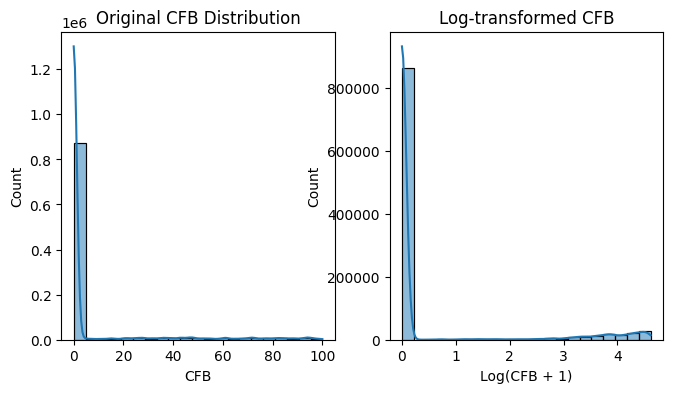

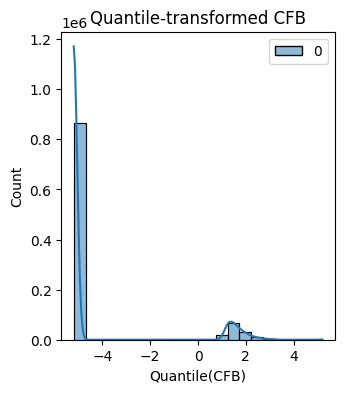

In [21]:
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

# 1. Analyze the original distribution
plt.figure(figsize=(12, 4))
plt.subplot(131)
sns.histplot(train_filled['cfb'], kde=True)
plt.title('Original CFB Distribution')
plt.xlabel('CFB')

# 2. Log transformation (adding a small constant to handle zeros)
log_cfb = np.log1p(train_filled['cfb'])
plt.subplot(132)
sns.histplot(log_cfb, kde=True)
plt.title('Log-transformed CFB')
plt.xlabel('Log(CFB + 1)')

# 4. Quantile transformation
qt = QuantileTransformer(output_distribution='normal')
quantile_cfb = qt.fit_transform(train_filled[['cfb']])

plt.figure(figsize=(12, 4))
plt.subplot(131)
sns.histplot(quantile_cfb, kde=True)
plt.title('Quantile-transformed CFB')
plt.xlabel('Quantile(CFB)')

# 5. Calculate skewness and kurtosis for each transformation
print("Skewness:")
print(f"Original: {stats.skew(train_filled['cfb'])}")
print(f"Log-transformed: {stats.skew(log_cfb)}")
#print(f"Box-Cox: {stats.skew(boxcox_cfb)}")
print(f"Quantile: {stats.skew(quantile_cfb)}")

print("\nKurtosis:")
print(f"Original: {stats.kurtosis(train_filled['cfb'])}")
print(f"Log-transformed: {stats.kurtosis(log_cfb)}")
#print(f"Box-Cox: {stats.kurtosis(boxcox_cfb)}")
print(f"Quantile: {stats.kurtosis(quantile_cfb)}")

# 6. Extreme value analysis
print("\nExtreme Values:")
print(train_filled['cfb'].describe(percentiles=[0.01, 0.05, 0.95, 0.99]))

In [22]:
from sklearn.utils.class_weight import compute_class_weight
from pytorch_forecasting.metrics import MAE, RMSE, SMAPE, QuantileLoss
import torch

# 1. Analyze the distribution of CFB values
zero_cfb_ratio = (train_filled['cfb'] == 0).mean()
print(f"Percentage of zero CFB values: {zero_cfb_ratio * 100:.2f}%")

# 2. Create a binary target for fire occurrence
train_filled['fire_occurrence'] = (train_filled['cfb'] > 0).astype(int)

# 3. Compute class weights for balanced learning
class_weights = compute_class_weight('balanced', classes=[0, 1], y=train_filled['fire_occurrence'])
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# 4. Custom loss function to handle imbalance
class WeightedQuantileLoss(QuantileLoss):
    def __init__(self, zero_weight=1.0, non_zero_weight=10.0, **kwargs):
        super().__init__(**kwargs)
        self.zero_weight = zero_weight
        self.non_zero_weight = non_zero_weight

    def loss(self, y_pred, y_actual):
        base_loss = super().loss(y_pred, y_actual)
        weights = torch.where(y_actual == 0, self.zero_weight, self.non_zero_weight)
        
        # Expand weights to match the shape of base_loss
        weights = weights.unsqueeze(-1).expand_as(base_loss)
        
        return (base_loss * weights).mean()

Percentage of zero CFB values: 86.99%


In [23]:
train_filled[train_filled['fire_occurrence'] >  0]

,locality,time_idx,index,cfb,lat,lon,temp,wd,elev,rh,...,bfc_lag5,bfc_lag6,bfc_lag7,hfi_lag1,hfi_lag2,hfi_lag3,hfi_lag5,hfi_lag6,hfi_lag7,fire_occurrence
193,100 Mile House,193,201.0,21.0,51.533333,-121.424334,26.8970,177.0,1204.0,23.0,...,6.253188,6.149034,6.149034,5924.666667,3986.666667,1903.000000,7856.333333,10833.0,10833.000000,1
194,100 Mile House,194,203.5,17.5,51.529999,-121.417000,25.9220,353.0,1200.0,29.0,...,6.461496,6.461496,6.305265,6099.000000,5447.500000,7935.500000,1903.000000,1903.0,6368.000000,1
195,100 Mile House,195,205.5,37.0,51.535824,-121.435665,28.5645,158.0,1209.5,27.0,...,6.887120,6.627117,6.461496,3624.500000,6333.500000,6099.000000,7935.500000,5028.5,1903.000000,1
196,100 Mile House,196,209.5,25.0,51.539834,-121.427333,29.5080,186.0,1205.5,22.0,...,5.960493,7.065743,6.991242,7429.333333,6030.166667,6595.166667,4834.666667,6078.0,5886.333333,1
197,100 Mile House,197,209.5,25.0,51.539834,-121.427333,29.5080,186.0,1205.5,22.0,...,5.960493,7.065743,6.991242,7429.333333,6030.166667,6595.166667,4834.666667,6078.0,5886.333333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991939,Zama City,1193,658725.0,82.4,59.884842,-118.182494,12.3760,315.0,628.8,42.0,...,0.089905,0.089905,0.089905,13068.800000,14432.200000,15889.000000,18501.800000,16335.8,14250.400000,1
991940,Zama City,1194,658725.0,82.4,59.884842,-118.182494,12.3760,315.0,628.8,42.0,...,0.089905,0.089905,0.089905,13068.800000,14432.200000,15889.000000,18501.800000,16335.8,14250.400000,1
991941,Zama City,1195,658725.0,82.4,59.884842,-118.182494,12.3760,315.0,628.8,42.0,...,0.089905,0.089905,0.089905,13068.800000,14432.200000,15889.000000,18501.800000,16335.8,14250.400000,1
991942,Zama City,1196,658725.0,82.4,59.884842,-118.182494,12.3760,315.0,628.8,42.0,...,0.089905,0.089905,0.089905,13068.800000,14432.200000,15889.000000,18501.800000,16335.8,14250.400000,1


In [24]:
## Define the data schema
static_reals=['elev']
time_varying_known_reals=['month', 'day', 'year']
time_varying_unknown_reals=['cfb', 'temp', 'wd',
       'rh', 'pcuring', 'ros', 'hfi', 'tfc0',
       'sfl', 'bui', 'cfl', 'sfc0', 'dmc', 'sfc',    
       'bfc', 'tfc', 'isi', 'fire_occurrence',
    'cfb_lag1', 'cfb_lag2', 'cfb_lag3', 'cfb_lag5', 'cfb_lag6', 'cfb_lag7',
    'dmc_lag1', 'dmc_lag2', 'dmc_lag3', 'dmc_lag5', 'dmc_lag6', 'dmc_lag7',
    'temp_lag1', 'temp_lag2', 'temp_lag3', 'temp_lag5', 'temp_lag6', 'temp_lag7',
    'tfc_lag1', 'tfc_lag2', 'tfc_lag3', 'tfc_lag5', 'tfc_lag6', 'tfc_lag7',
    'ros_lag1', 'ros_lag2', 'ros_lag3', 'ros_lag5', 'ros_lag6', 'ros_lag7',
    'pcuring_lag1', 'pcuring_lag2', 'pcuring_lag3', 'pcuring_lag5', 'pcuring_lag6', 'pcuring_lag7',
    'bfc_lag1', 'bfc_lag2', 'bfc_lag3', 'bfc_lag5', 'bfc_lag6', 'bfc_lag7',
    'hfi_lag1', 'hfi_lag2', 'hfi_lag3', 'hfi_lag5', 'hfi_lag6', 'hfi_lag7']
max_prediction_length = 7  # predict 7 days ahead
max_encoder_length = 30  # use 30 days of history

# keep the validation set held-out
training_cutoff = train["time_idx"].max() - max_prediction_length

In [25]:
from sklearn.preprocessing import StandardScaler
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss

target_normalizer = GroupNormalizer(
    groups=['locality'], 
    transformation="softplus"
)
# target_normalizer.fit(train_filled['cfb'], train_filled)

train_dataset = TimeSeriesDataSet(
    train_filled[lambda x: x.time_idx <= training_cutoff],
    time_idx='time_idx',
    target='cfb',
    group_ids=['locality'],
    static_reals=static_reals,
    time_varying_known_reals=time_varying_known_reals,
    time_varying_unknown_reals=time_varying_unknown_reals,
    max_encoder_length=max_encoder_length,
    min_encoder_length=max_encoder_length//2,  
    max_prediction_length=max_prediction_length,
    min_prediction_length=max_prediction_length,
    target_normalizer=target_normalizer,
    add_relative_time_idx=True,
    add_target_scales=True,
    lags = {
        "cfb": [1, 2, 3, 5, 6, 7]
    }
)

In [26]:
# create validation set (predict=True)
validation_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    train_filled,
    predict=True,
    stop_randomization=True,
)

In [27]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint

# Define the model
# Use the weighted loss in the model definition
tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    learning_rate=1e-3,
    hidden_size=64,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=32,
   # output_size=7,  # number of quantiles
    loss=WeightedQuantileLoss(zero_weight=1.0, non_zero_weight=10.0),  # Adjust weights as needed
    log_interval=10,
    reduce_on_plateau_patience=10
)

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [28]:
# define callbacks
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger(save_dir='/kaggle/working/models')  # log results to a tensorboard
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',   # Metric to monitor
    dirpath='/kaggle/working/checkpoints',  # Directory to save the checkpoints
    filename='best-checkpoint',  # Filename for the best checkpoint
    save_top_k=1,   # Save only the best model
    mode='min'  # Mode of the monitored metric ('min' or 'max')
)
# create trainer
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # run validation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    log_every_n_steps=10,
    callbacks=[lr_logger, early_stop_callback, checkpoint_callback],
    logger=logger,
)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


In [29]:
# Function to print batch shapes
def print_batch_shapes(dataloader, name):
    for i, batch in enumerate(dataloader):
        x, y = batch
        print(f"{name} Batch {i+1}:")
        print(f"  Inputs shape: {x['encoder_cont'].shape}")
        print(f"  Decoder shape: {x['decoder_cont'].shape}")
    #    print(f"  Static real shape: {x['static_cont'].shape}")
      #  print(f"  Targets shape: {len(y)}")
        # Print only the first batch to avoid too much output
        break


In [30]:
# Create dataloaders
batch_size = 64
train_dataloader = train_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=4)

# Print shapes for train and validation dataloaders
print_batch_shapes(train_dataloader, "Train")
print_batch_shapes(val_dataloader, "Validation")

# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Train Batch 1:
  Inputs shape: torch.Size([64, 30, 80])
  Decoder shape: torch.Size([64, 7, 80])
Validation Batch 1:
  Inputs shape: torch.Size([640, 30, 80])
  Decoder shape: torch.Size([640, 7, 80])


2024-08-07 17:31:03.218131: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 17:31:03.218241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 17:31:03.360620: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | WeightedQuantileLoss            | 0      | train
1  | logging_metrics           

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]